In [2]:
#!/usr/bin/env python
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# y is a 1-channel image
# ycrcb is a 3-channels image
# colorize function aggregates y and ycrcb's 2st, 3st channel, to generate a 3-channels image for displaying
def colorize(y, ycrcb):
    y[y>255] = 255
    y[y<0] = 0
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycrcb[:,:,1]
    img[:,:,2] = ycrcb[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCR_CB2RGB)
    
    return img

model_def = caffe_root + 'examples/SRCNN/SRCNN_deploy_motion_deblur.prototxt'
model_weights = caffe_root + 'examples/SRCNN/motion_deblur_iter_50000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [13]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [16]:
# Inputs
im_raw = cv2.imread(caffe_root + 'examples/SRCNN/length40_angle_40/blurred_image_929.jpg')

'''
print 'original shape:', im_raw.shape

im_raw = cv2.resize(im_raw, ((im_raw.shape[1] - im_raw.shape[1] % zooming), 
                             (im_raw.shape[0] - im_raw.shape[0] % zooming))
                   )

print 'resized shape:', im_raw.shape
'''
im_pad = cv2.copyMakeBorder(im_raw,25,25,25,25,cv2.BORDER_REPLICATE)
ycrcb_orig = cv2.cvtColor(im_pad, cv2.COLOR_RGB2YCR_CB)
ycrcb = ycrcb_orig
im_pad = ycrcb[:,:,0]
im_pad = im_pad.reshape((im_pad.shape[0], im_pad.shape[1], 1))

im_input = im_pad

#image_mean = np.load(input_dir + 'image_mean.npy')
# net.set_mean('data', image_mean)
caffe_transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
caffe_transformer.set_transpose('data', (2, 0, 1))
caffe_transformer.set_raw_scale('data', 255.0)
out = net.forward_all(data=np.asarray([caffe_transformer.preprocess('data', im_input.astype(float)/255)]))

# Predict results
mat = out['conv3'][0]

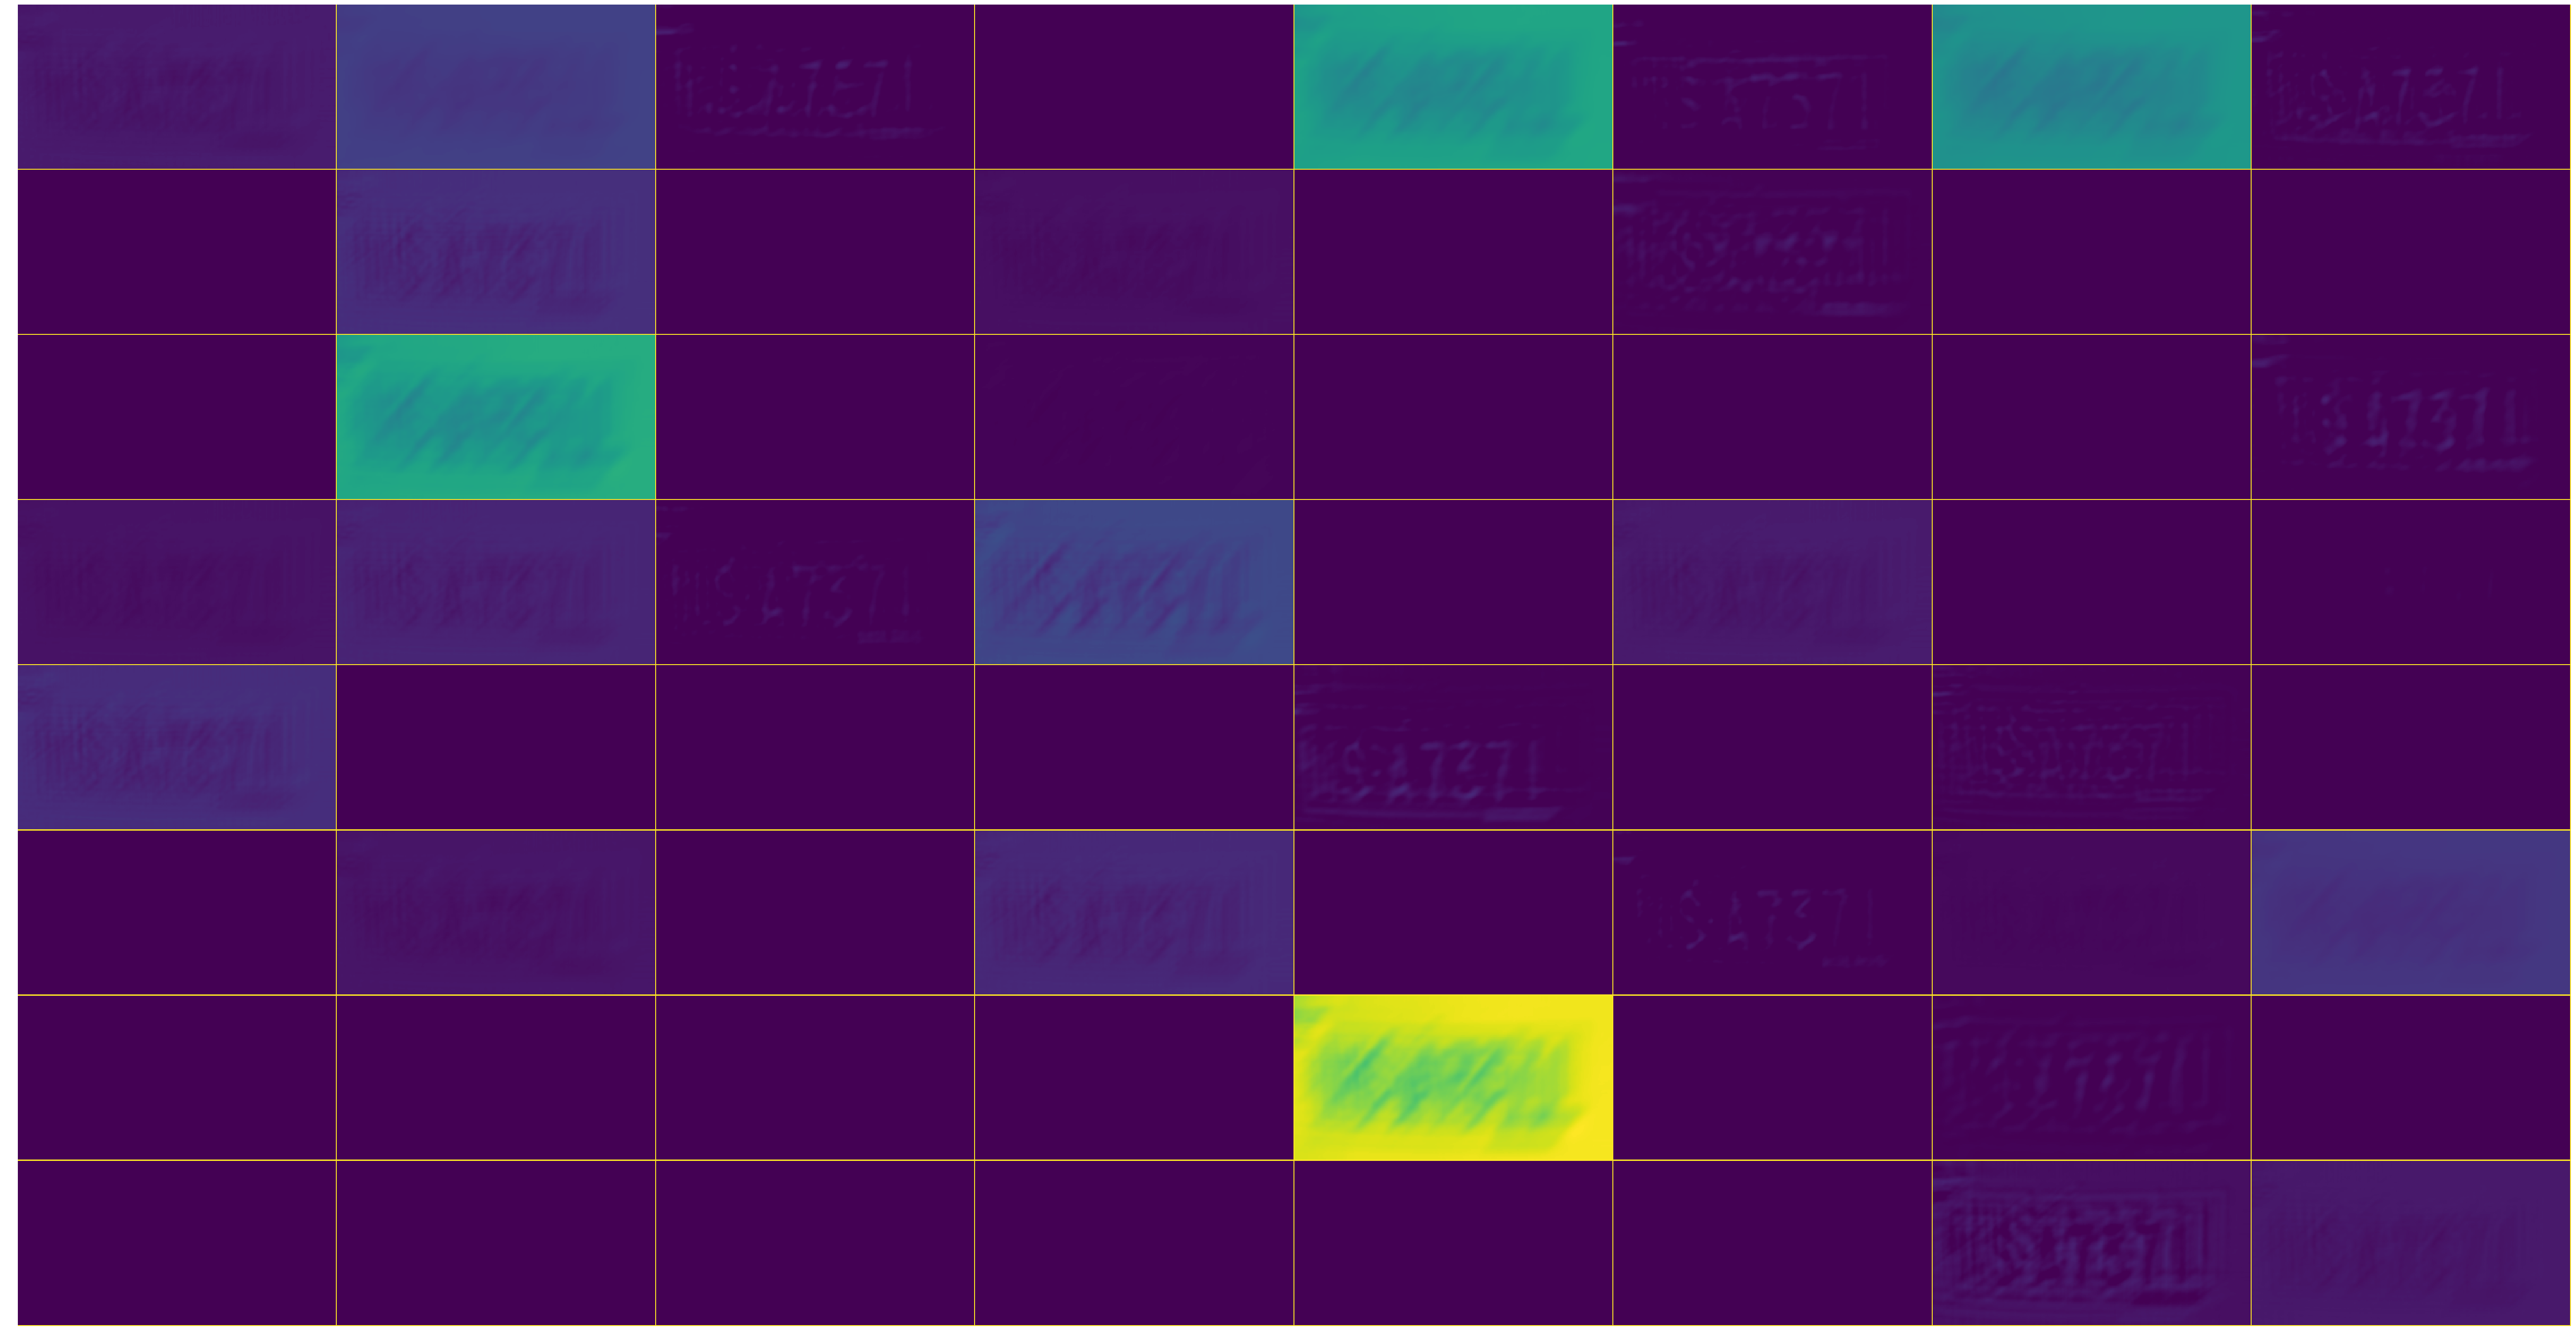

In [17]:
plt.rcParams['figure.figsize'] = (100, 100)
mat1 = net.blobs['conv1'].data[0]
vis_square(mat1)

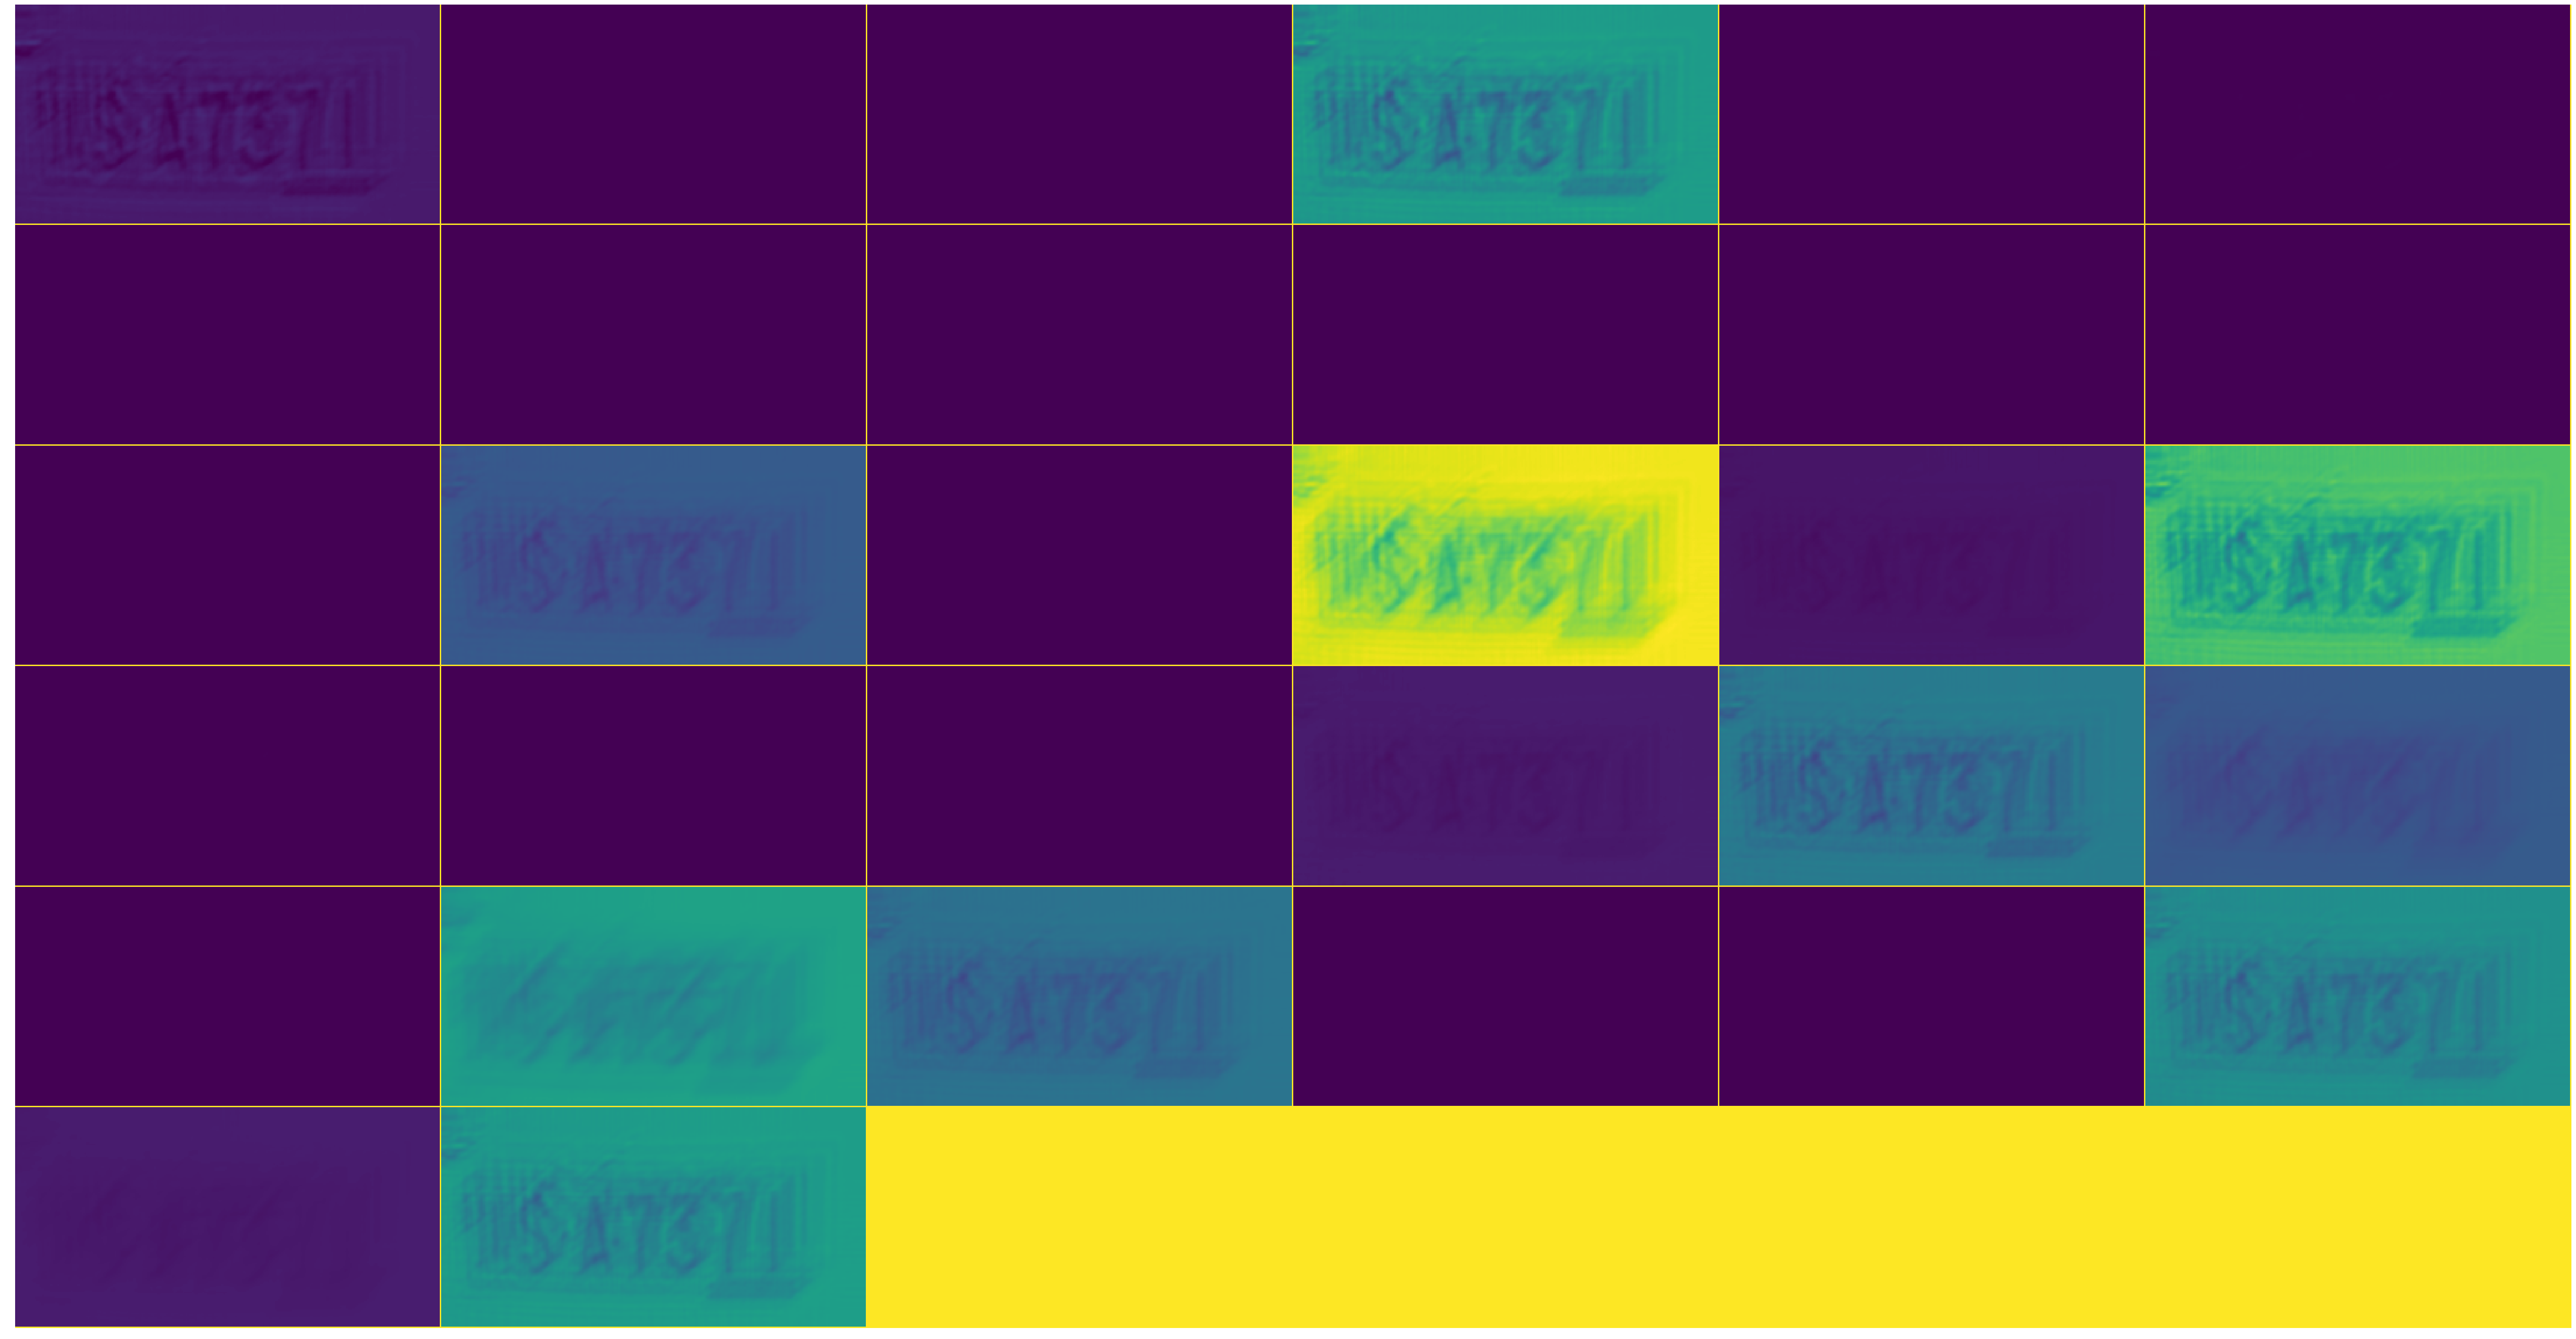

In [18]:
mat2 = net.blobs['conv2'].data[0]
vis_square(mat2)

In [8]:
# Show
ycrcb = ycrcb_orig
ycrcb = ycrcb[25:-25,25:-25,:] # remove the edge effect
im_pred = colorize(mat[0,:,:], ycrcb)
im_input = colorize(im_input[25:-25,25:-25,0], ycrcb)

cv2.imwrite('input.png', im_input)
cv2.imwrite('recon.png', im_pred)
diff = im_input - im_pred
cv2.imwrite('diff.png', diff)

True